In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [2]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=8);
    plt.yscale('log')

## CoinMetrics

In [5]:
data = OrderedDict()

# Список финансовых инструментов в портфеле
TIKERS = ['BTC']

# Данные которые будут использоваться в дальнейшем
#COLUMNS = ['PriceUSD', 'NVTAdj', 'NVTAdj90']

In [6]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/Coinmetrics/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    #data[tiker] = pd.read_csv("data/{}.csv".format(tiker), parse_dates=['date'])
    #data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['index'] = range(0, len(data[tiker]))
    
    data[tiker]['date'] = data[tiker].index
    
    data[tiker] = data[tiker].set_index('index')
    
    data[tiker] = data[tiker].loc[data[tiker]['date'] >= datetime(2010, 10, 15)]
    data[tiker] = data[tiker].loc[data[tiker]['date'] <= datetime(2020, 3, 11)]

    data[tiker] = data[tiker].set_index('date')
    data[tiker] = data[tiker].rename({'PriceUSD': 'price'}, axis=1)
    print(data[tiker].head())

            AdrActCnt  BlkCnt  BlkSizeByte  BlkSizeMeanByte  CapMVRVCur  \
date                                                                      
2010-10-15        582     177        94279       532.649718    4.343539   
2010-10-16        933     258       147280       570.852713    4.069854   
2010-10-17        751     270       131729       487.885185    4.062779   
2010-10-18        947     249       182193       731.698795    4.029949   
2010-10-19       1411     256       298693      1166.769531    3.807617   

            CapMrktCurUSD     CapRealUSD     DiffMean  FeeMeanNtv  FeeMeanUSD  \
date                                                                            
2010-10-15  448087.500000  103161.854771  1378.028165    0.000000    0.000000   
2010-10-16  432320.400000  106225.031607  1378.028165    0.000000    0.000000   
2010-10-17  437977.800000  107802.507789  1378.028165    0.000000    0.000000   
2010-10-18  440970.240000  109423.286698  1378.028165    0.000061    

In [9]:
data['BTC'].columns

Index(['AdrActCnt', 'BlkCnt', 'BlkSizeByte', 'BlkSizeMeanByte', 'CapMVRVCur',
       'CapMrktCurUSD', 'CapRealUSD', 'DiffMean', 'FeeMeanNtv', 'FeeMeanUSD',
       'FeeMedNtv', 'FeeMedUSD', 'FeeTotNtv', 'FeeTotUSD', 'HashRate',
       'IssContNtv', 'IssContPctAnn', 'IssContUSD', 'IssTotNtv', 'IssTotUSD',
       'NVTAdj', 'NVTAdj90', 'PriceBTC', 'price', 'ROI1yr', 'ROI30d',
       'SplyCur', 'TxCnt', 'TxTfrCnt', 'TxTfrValAdjNtv', 'TxTfrValAdjUSD',
       'TxTfrValMeanNtv', 'TxTfrValMeanUSD', 'TxTfrValMedNtv',
       'TxTfrValMedUSD', 'TxTfrValNtv', 'TxTfrValUSD', 'VtyDayRet180d',
       'VtyDayRet30d', 'VtyDayRet60d'],
      dtype='object')

In [8]:
data['BTC'].corr(method = 'pearson').values[23]

array([ 0.77290036, -0.12497084,  0.71793189,  0.7070909 ,  0.00864136,
        0.99919846,  0.91345086,  0.75811215, -0.07050484,  0.55283606,
        0.08112313,  0.52001805,  0.40309639,  0.54174204,  0.76328438,
       -0.54882111, -0.42275249,  0.98940334, -0.54882111,  0.98940334,
        0.19157952,  0.11155031,         nan,  1.        , -0.12666502,
       -0.07567024,  0.63809629,  0.70181913,  0.69536918,  0.0206688 ,
        0.90061636, -0.19896068,  0.802834  , -0.08293168,  0.85996768,
       -0.09356609,  0.78792543, -0.17403853, -0.06450011, -0.09808215])

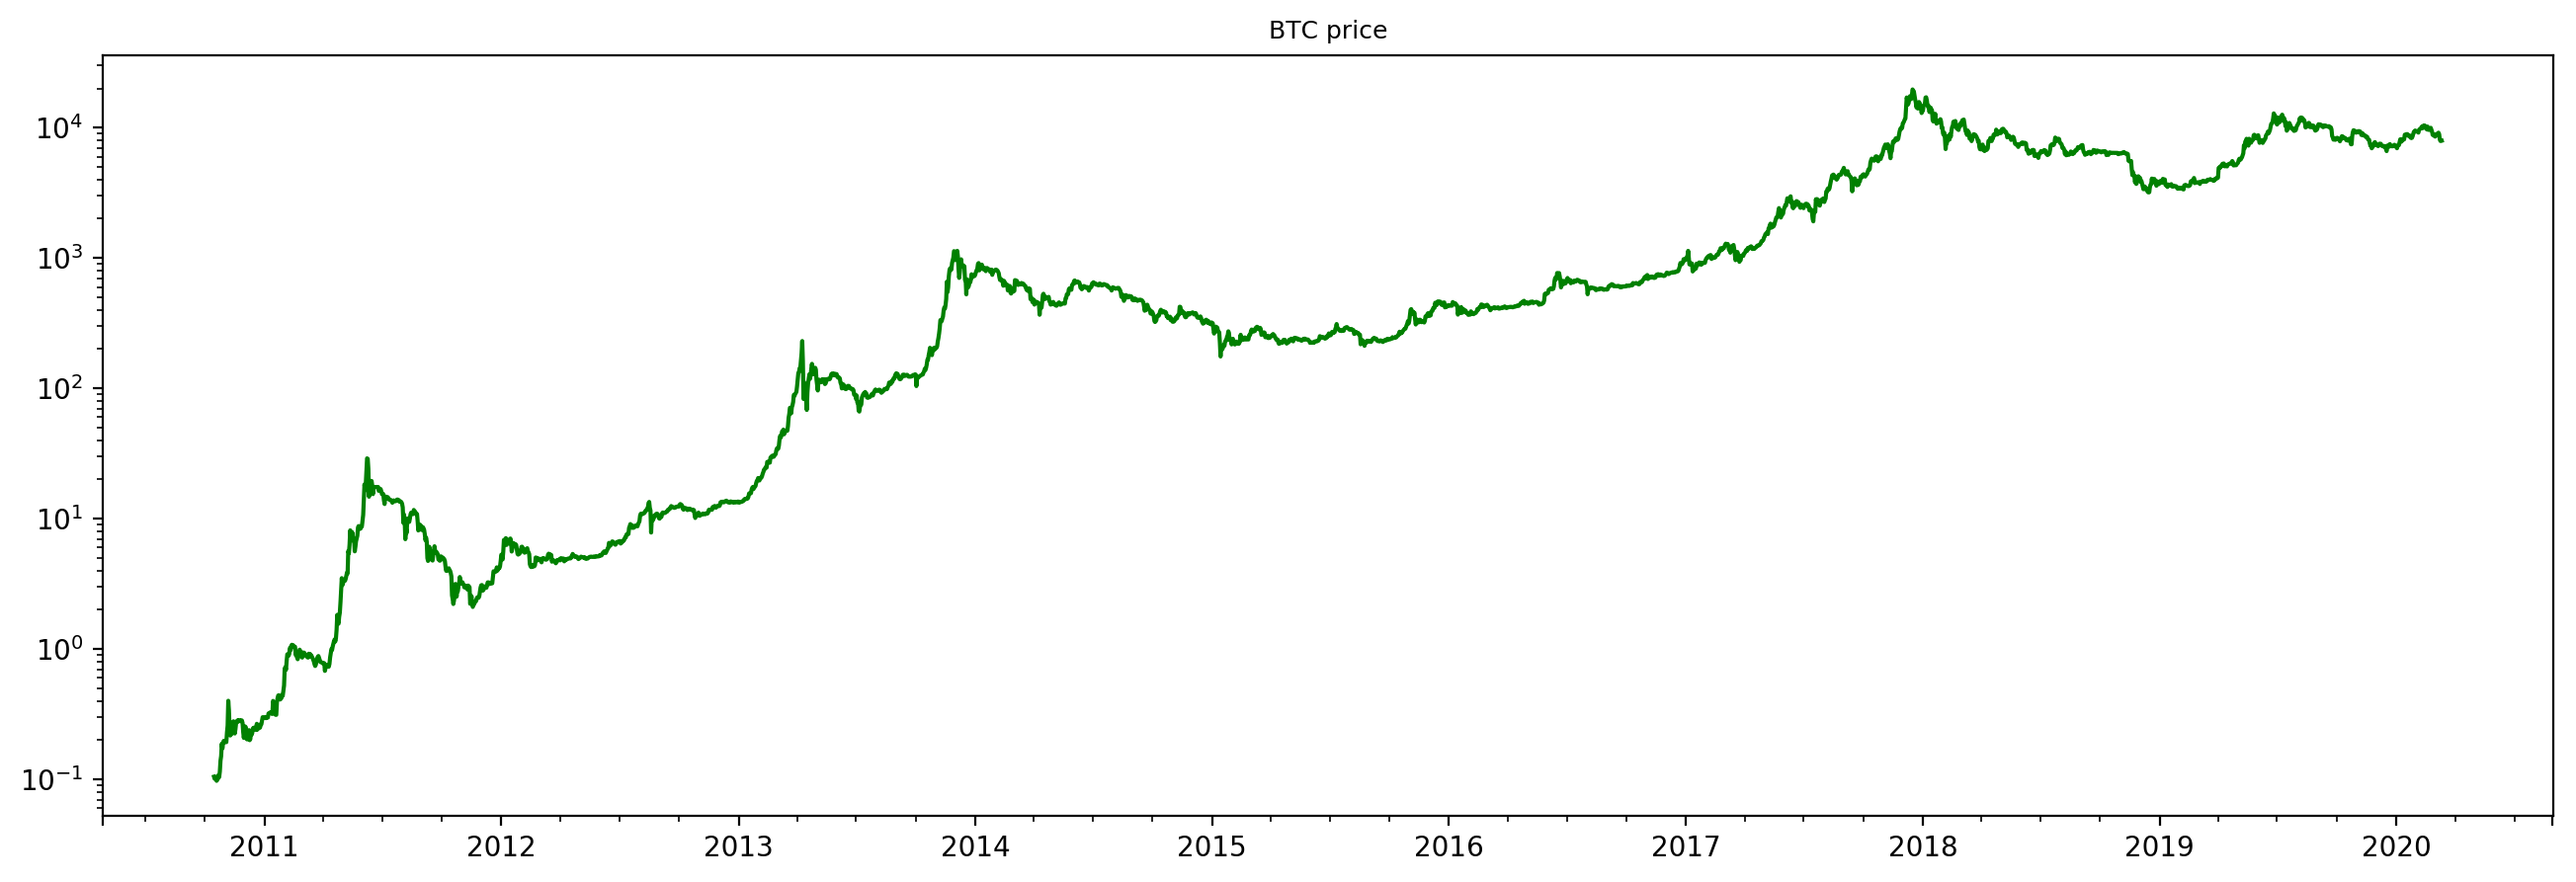

7939.34133477499


In [9]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
data['BTC']['price'].plot(color='g')
ax.set_xlabel('')
#ax.tick_params(axais = 'x', direction = 'out')

#plt.legend()
#plt.yscale('log')
plt.title('BTC price', fontsize = 9)
plt.yscale('log')
plt.show()

print(data['BTC']['price'][-1])

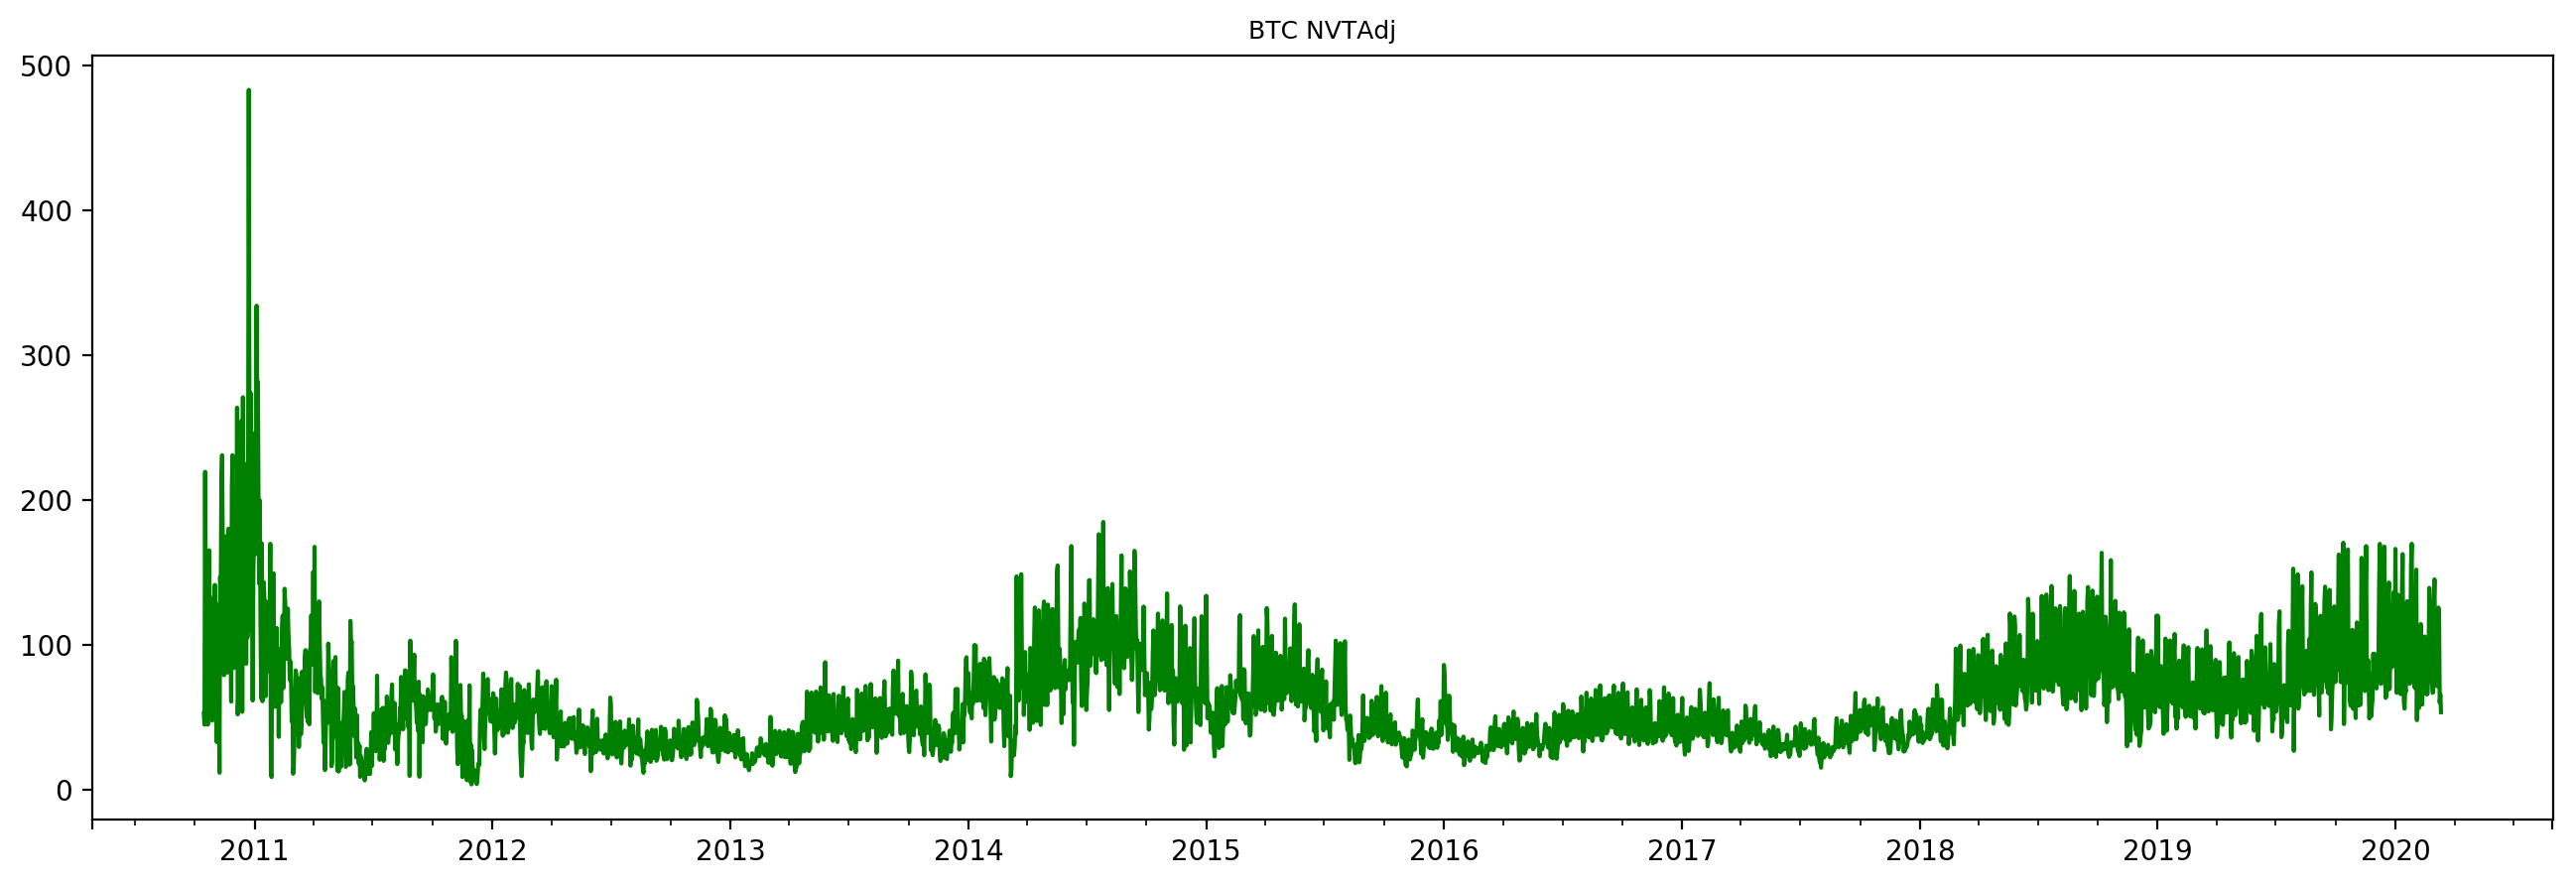

53.52514045


In [10]:
fig, ax = plt.subplots(figsize=[16, 5])

# portfolio value
data['BTC']['NVTAdj'].plot(color='g')
ax.set_xlabel('')
#ax.tick_params(axais = 'x', direction = 'out')

#plt.legend()
#plt.yscale('log')
plt.title('BTC NVTAdj', fontsize = 9)
#plt.yscale('log')
plt.show()

print(data['BTC']['NVTAdj'][-1])

In [11]:
data['BTC'].corr(method='pearson')

,price,NVTAdj,NVTAdj90
price,1.00000,0.191580,0.111550
NVTAdj,0.19158,1.000000,0.428993
NVTAdj90,0.11155,0.428993,1.000000


In [12]:
data['BTC'].corr(method='pearson').values[0][1]

0.19157951944894455

In [13]:
corr_list = []
corr_list.append(data['BTC'].corr(method='pearson').values[0][1])

In [14]:
for shift in tqdm(range(0, 300)):
    data['BTC'].NVTAdj = data['BTC'].NVTAdj.shift(1)
    data['BTC'].dropna()
    corr_list.append(data['BTC'].corr(method='pearson').values[0][1])

100%|██████████| 300/300 [00:00<00:00, 949.09it/s]


In [65]:
#corr_list

In [15]:
for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/Coinmetrics/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    #data[tiker] = pd.read_csv("data/{}.csv".format(tiker), parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    
    data[tiker]['index'] = range(0, len(data[tiker]))
    
    data[tiker]['date'] = data[tiker].index
    
    data[tiker] = data[tiker].set_index('index')
    
    data[tiker] = data[tiker].loc[data[tiker]['date'] >= datetime(2010, 10, 15)]
    data[tiker] = data[tiker].loc[data[tiker]['date'] <= datetime(2020, 3, 11)]

    data[tiker] = data[tiker].set_index('date')
    data[tiker] = data[tiker].rename({'PriceUSD': 'price'}, axis=1)
    print(data[tiker].head())

               price      NVTAdj    NVTAdj90
date                                        
2010-10-15  0.105000   52.689023  154.643925
2010-10-16  0.101000   44.927385  144.681892
2010-10-17  0.102000  219.478535  147.263082
2010-10-18  0.102400   81.493029  145.972987
2010-10-19  0.097545   87.839037  137.869691


In [16]:
neg_corr_list = []
for shift in tqdm(range(0, 300)):
    data['BTC'].NVTAdj = data['BTC'].NVTAdj.shift(-1)
    data['BTC'].dropna()
    neg_corr_list.append(data['BTC'].corr(method='pearson').values[0][1])

100%|██████████| 300/300 [00:00<00:00, 965.65it/s]


In [17]:
neg_corr_list.reverse()

In [18]:
#neg_corr_list

In [19]:
final_list = neg_corr_list + corr_list

In [20]:
len(final_list)

601

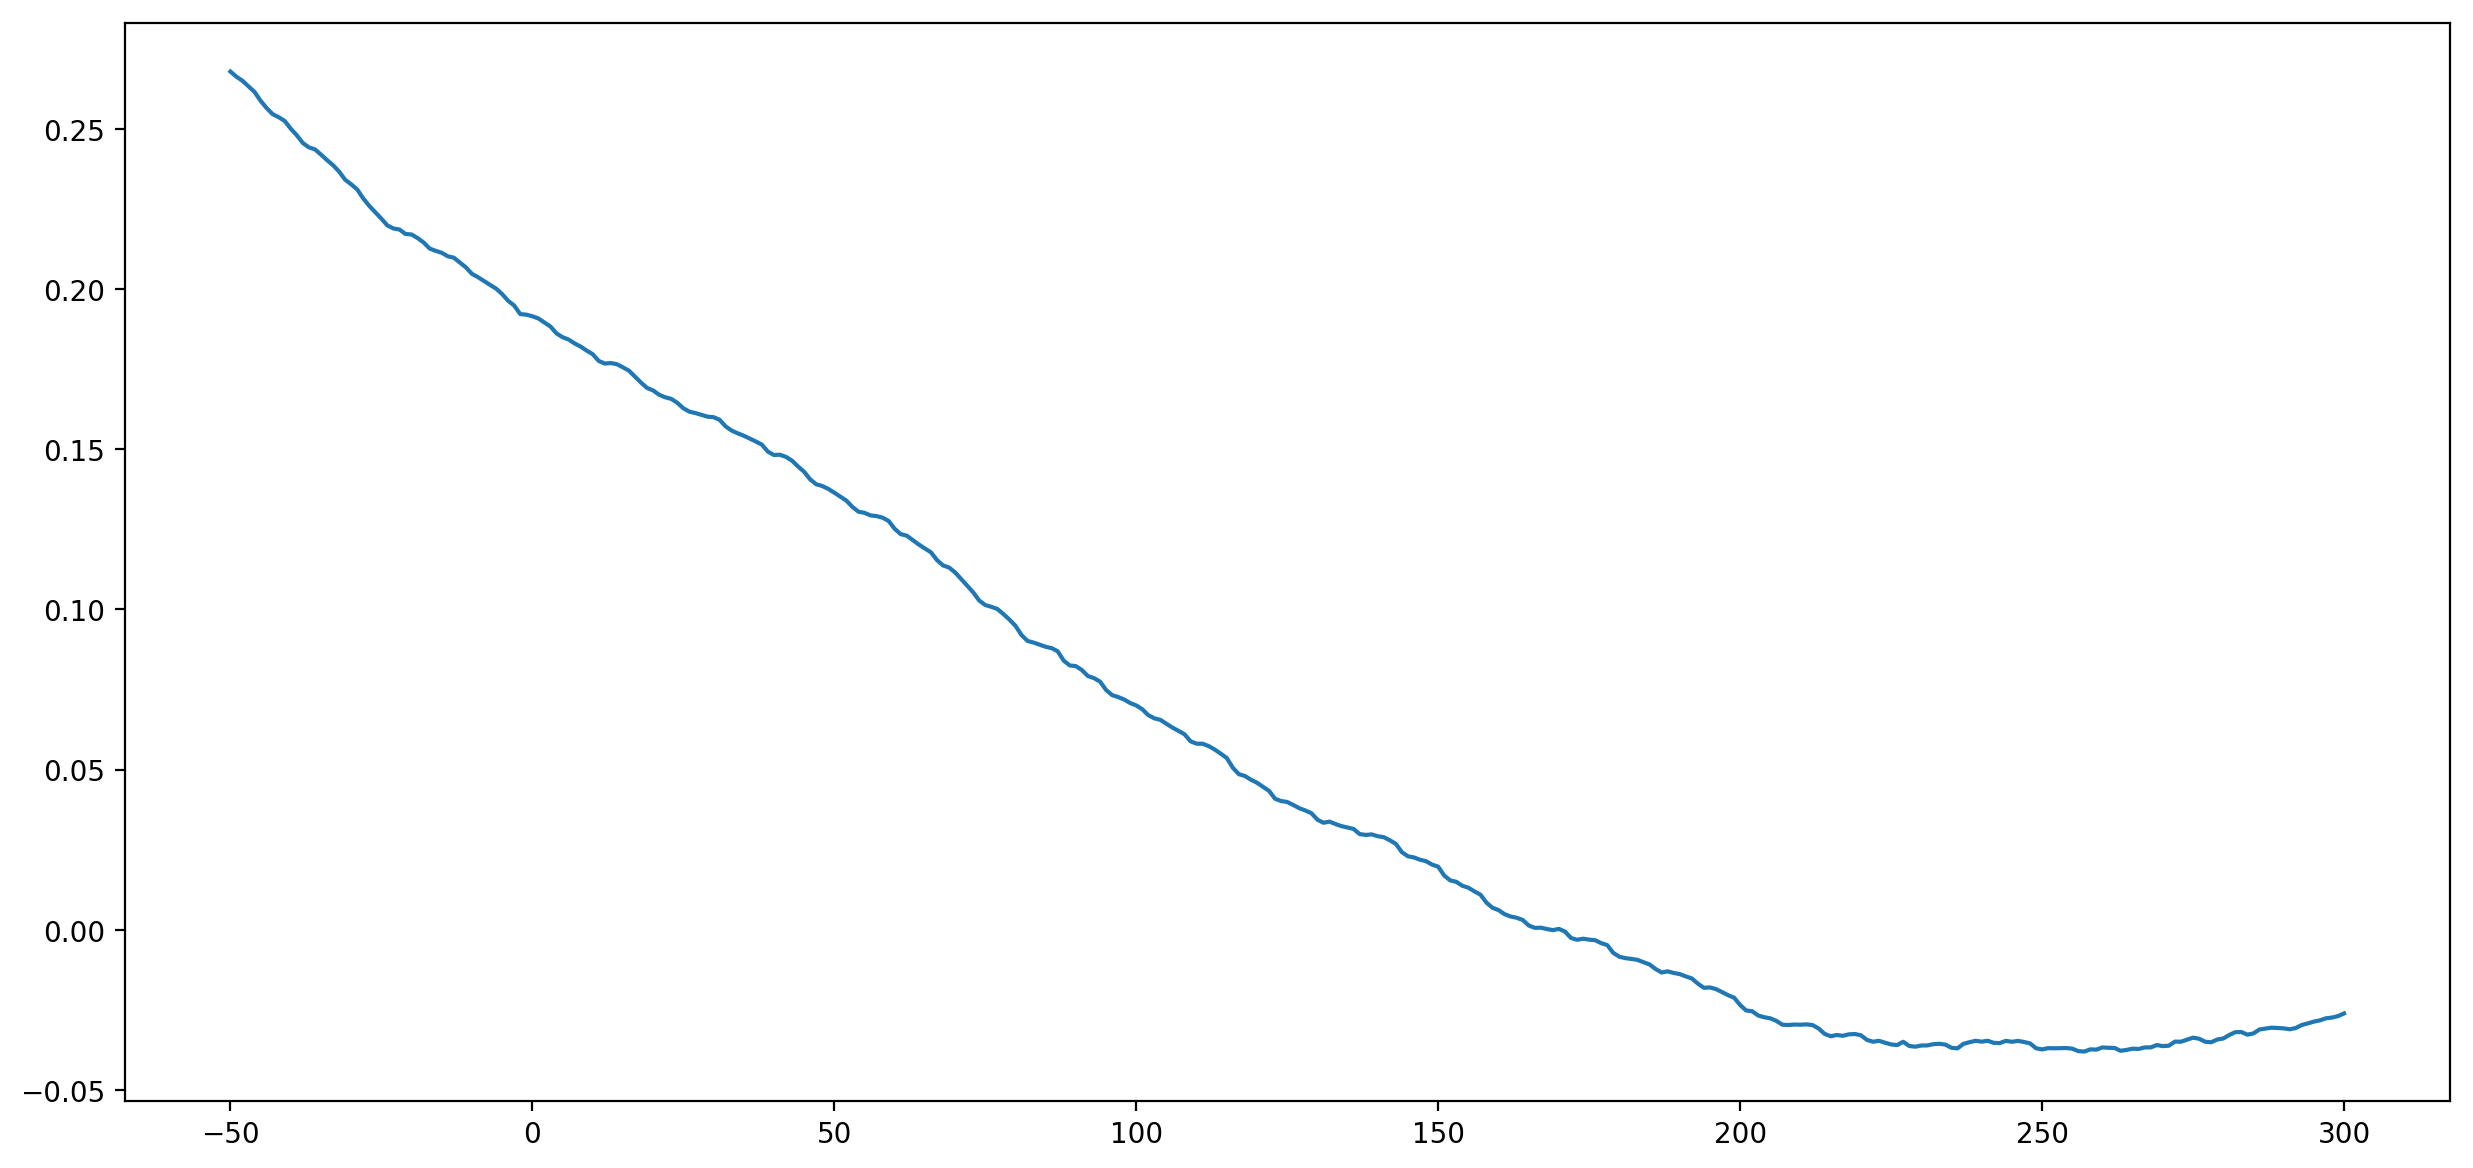

In [21]:
xlist = range(-50, 301)
ylist = final_list[250:601]
plt.plot(xlist, ylist)
plt.show()